# Architecture - Semantic Search using Elastic Search

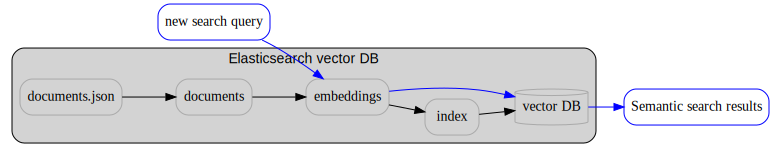

In [ ]:
from graphviz import Digraph
from IPython.display import Image, display

# Create the graph
dot = Digraph(comment='Elasticsearch Vector DB Flow')
dot.attr(rankdir='LR')  # Left-to-right direction
dot.attr('node', shape='box', style='rounded')  # Rounded rectangles
dot.attr(fontname='Arial')  # Set font

# Set subgraph style
with dot.subgraph(name='cluster_elasticsearch') as es:
   es.attr(label='Elasticsearch vector DB',
          style='rounded',  # Rounded border
          bgcolor='lightgrey')  # Background color

   # Add nodes (with styling)
   es.node('A', 'documents', color='darkgrey')
   es.node('B', 'documents.json', color='darkgrey')
   es.node('C', 'embeddings', color='darkgrey')
   es.node('D', 'index', color='darkgrey')
   es.node('E', 'vector DB', shape='cylinder', color='darkgrey')

   # Add edges
   es.edge('B', 'A')
   es.edge('A', 'C')
   es.edge('C', 'D')
   es.edge('C', 'E', color='blue')  # Change this edge to blue
   es.edge('D', 'E')

# External nodes (with styling)
dot.node('F', 'new search query', color='blue')
dot.node('G', 'Semantic search results', color='blue')
dot.edge('F', 'C', color='blue')
dot.edge('E', 'G', color='blue')

# Display
display(dot)


Two very important concepts in Elasticsearch are documents and indexes.

A document is collection of fields with their associated values.

To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index.

Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

# Step 1: Prepare documents

In [ ]:
import json
import requests

In [ ]:
url = "https://raw.githubusercontent.com/AD2000X/llm-zoomcamp/refs/heads/main/01-intro/documents.json"
response = requests.get(url)

In [ ]:
if response.status_code == 200:
    doc_raw = json.loads(response.text)
    print("JSON data loaded successfully")
    print(f"Number of items in the JSON: {len(doc_raw)}")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

JSON data loaded successfully
Number of items in the JSON: 3


In [ ]:
doc_raw[0]

{'course': 'data-engineering-zoomcamp',
 'documents': [{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
   'section': 'General course-related questions',
   'question': 'Course - When will the course start?'},
  {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
   'section': 'General course-related questions',
   'question': 'Course - What are the prerequisites for this course?'},
  {'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the fin

In [ ]:
doc_raw[1]

{'course': 'machine-learning-zoomcamp',
 'documents': [{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
   'section': 'General course-related questions',
   'question': 'How do I sign up?'},
  {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
   'section': 'General course-related questions',
   'question': 'Is it going to be live? When?'},

In [ ]:
doc_raw[2]

{'course': 'mlops-zoomcamp',
 'documents': [{'text': 'MLOps Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course, and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\n[Problem description]\n[Solution description]\n(optional) Added by Name',
   'section': '+-General course questions',
   'question': 'Format for questions: [Problem title]'},
  {'text': 'Approximately 3 months. For each module, about 1 week with possible deadline extensions (in total 6~9 weeks), 2 weeks for working on the capstone project and 1 week for peer review.',
   'section': '+-General course questions',
   'question': 'What is the expected duration of this course or that for each module?'},
  {'text': 'The difference is the Orchestration and Monitoring modules. Those videos will be re-recorded. The rest should mostly be the same.\nAlso all o

In [ ]:
# documents = []

# for course_dict in doc_raw:
#     for doc in course_dict['documents']:
#         doc['course'] = course_dict['course']
#         documents.append(doc)

# documents[1]

In [ ]:
# What this process does:

# Flattening:
# Transforms from a nested structure (3 main documents, each containing multiple sub-documents)
# into a flat structure (all sub-documents at the same level)

# Data integration:
# Copies the 'course' value from the main document to each sub-document
# Retains all original information from each sub-document

# Result:
# Transforms from 3 main documents, each with multiple sub-documents,
# into a single list containing all sub-documents
# Each sub-document now has complete information (including 'course')

# Benefits of this approach:
# - Simpler data structure (flattened)
# - Each document is self-contained (includes all necessary information)
# - Easier to handle in further processing (e.g., embedding)

documents = []  # Create an empty list to store the flattened documents

for course_dict in doc_raw:  # Iterate over each main document (3 in total)
    # Example structure of course_dict:
    # {
    #   "course": "data-engineering-zoomcamp",
    #   "documents": [{ "text": "...", "section": "...", "question": "..." }, ...]
    # }

    for doc in course_dict['documents']:  # Iterate over each sub-document in the main document
        # Example structure of doc:
        # {
        #   "text": "...",
        #   "section": "...",
        #   "question": "..."
        # }

        doc['course'] = course_dict['course']  # Add the 'course' value from the main document to the sub-document
        documents.append(doc)  # Append the updated sub-document to the documents list

# View the second document after processing
print("Second document after processing:")
print(json.dumps(documents[1], indent=2))

Second document after processing:
{
  "text": "GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites",
  "section": "General course-related questions",
  "question": "Course - What are the prerequisites for this course?",
  "course": "data-engineering-zoomcamp"
}


In [ ]:
# Check structure before and after transformation
print("1. Before transformation (structure of doc_raw[0]):")
print(json.dumps({
    'course': doc_raw[0]['course'],
    'documents': doc_raw[0]['documents'][:2]  # Display only the first two documents
}, indent=2))

print("\n2. After transformation (first two documents in the documents list):")
print(json.dumps(documents[:2], indent=2))

print("\n3. Change in quantity:")
print(f"Original number of main documents: {len(doc_raw)}")
print(f"Number of documents after processing: {len(documents)}")

print("\n4. Example of the processing:")
print("First iteration:")
print(f"Extracted course from doc_raw[0]: {doc_raw[0]['course']}")
print("Adding this course value to each sub-document")



1. Before transformation (structure of doc_raw[0]):
{
  "course": "data-engineering-zoomcamp",
  "documents": [
    {
      "text": "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  \u201cOffice Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon\u2019t forget to register in DataTalks.Club's Slack and join the channel.",
      "section": "General course-related questions",
      "question": "Course - When will the course start?",
      "course": "data-engineering-zoomcamp"
    },
    {
      "text": "GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites",
      "section": "General course-related questions",
      "question": "Course - What are the prerequisites for this course?",
      "course":

In [ ]:
doc.keys()

dict_keys(['text', 'section', 'question', 'course'])

In [ ]:
# Check keys at the main level
print("Keys at the main level:")
for i, doc in enumerate(doc_raw):
    print(f"Keys of doc_raw[{i}]: {list(doc.keys())}")

# Check keys in sub-documents
print("\nKeys in sub-documents:")
if 'documents' in doc_raw[0]:
    sub_keys = set()
    for doc in doc_raw[0]['documents']:
        sub_keys.update(doc.keys())
    print(f"Keys in documents: {sub_keys}")

Keys at the main level:
Keys of doc_raw[0]: ['course', 'documents']
Keys of doc_raw[1]: ['course', 'documents']
Keys of doc_raw[2]: ['course', 'documents']

Keys in sub-documents:
Keys in documents: {'question', 'section', 'course', 'text'}


# Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [ ]:
# This is a new library compared to the previous modules.
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
len(model.encode("This is a simple sentence"))

768

In [ ]:
#created the dense vector using the pre-trained model
#add text_vector in the data structure
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [ ]:
# add 'text_vector': [...] column
operations[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'text_vector': [-0.041030365973711014,
  0.025834113359451294,
  -0.03680190443992615,
  -0.020898321643471718,
  -0.020596224814653397,
  0.009353751316666603,
  -0.003331663552671671,
  -0.009491917677223682,
  0.030117962509393692,
  0.01908213458955288,
  0.012690077535808086,
  -0.01707884483039379,
  -0.0016323969466611743,
  0.12997259199619293,
  0.030969293788075447,
  -0.025823693722486496,
  0.027823051437735558,
  0.025159766897559166,
  -0.08081220090389252,
  -0.0036174175329506397,
  -0.008902004919946194,
  0.0034048743546009064,
  -0.023009298369288445,
  -0.03404533490538597,
  0.024598602205514908,
  0.013545621186494827,
  -0.025438977405428886,
  0.011951080523431301,
  -0.020540107041597366,
  -0.010077476501464844,
  0.020575320348143

# Step 3: Setup ElasticSearch connection

In [ ]:
!pip install elasticsearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.1/543.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import logging
import os
from elasticsearch import Elasticsearch
from google.colab import userdata
from getpass import getpass

# Elastic Cloud ID and API Key in Colab environment
ELASTIC_CLOUD_ID = userdata.get('ELASTIC_CLOUD_ID')
ELASTIC_API_KEY = userdata.get('ELASTIC_API_KEY')

In [ ]:
# Create the client
es_client = Elasticsearch(
    cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
    timeout=60  # increase timeout
)

# Check connection
if es_client.ping():
    print('Successfully connected to Elasticsearch')
    print(es_client.info())
else:
    print('Could not connect to Elasticsearch')

<ipython-input-19-8ccd663a8f18>:2: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  es_client = Elasticsearch(


Successfully connected to Elasticsearch
{'name': 'instance-0000000001', 'cluster_name': 'bd5c04e72b0c4673b4cbd3db98fdb86b', 'cluster_uuid': 'K11-nm1NQeu_GpxDE5TTJg', 'version': {'number': '8.14.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'd55f984299e0e88dee72ebd8255f7ff130859ad0', 'build_date': '2024-07-07T22:04:49.882652950Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


# Step 4: Create Mappings and Index
Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

Each document is a collection of fields, which each have their own data type.

We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored

In [ ]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },

# create all hte meta data information
# specify "dims": 768,
# specify "similarity": "cosine"
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [ ]:
# index_settings = {
#     # 1. Basic index settings
#     "settings": {
#         "number_of_shards": 1,    # Divide the index into 1 shard, suitable for small datasets
#         "number_of_replicas": 0    # No replicas created to save space, suitable for development environment
#     },

#     # 2. Field mapping definitions
#     "mappings": {
#         "properties": {
#             # 2.1 Text field - for full-text search
#             "text": {
#                 "type": "text"     # Text type that will be tokenized
#             },

#             # 2.2 Section field - for full-text search
#             "section": {
#                 "type": "text"     # Text type that will be tokenized
#             },

#             # 2.3 Question field - for full-text search
#             "question": {
#                 "type": "text"     # Text type that will be tokenized
#             },

#             # 2.4 Course field - for exact match
#             "course": {
#                 "type": "keyword"  # Non-tokenized, used for exact matching and filtering
#             },

#             # 2.5 Text vector field - for vector search
#             "text_vector": {
#                 "type": "dense_vector",  # Dense vector type
#                 "dims": 768,             # Vector dimension is 768 (to match the output dimension of the embedding model)
#                 "index": True,           # Enables vector indexing, supporting vector search
#                 "similarity": "cosine"   # Uses cosine similarity to calculate similarity between vectors
#             }
#         }
#     }
# }


In [ ]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [ ]:
# Why do this?

# Ensuring a clean start:

# Deleting the old index avoids:
# Interference from outdated data
# Structural inconsistencies
# Duplicate data

# Correct order:
# First, have the “library” (index)
# Then, define the “classification system” (mappings)
# Only then can we add the “books” (documents)

In [ ]:
# # 1. Define the index name
# index_name = "course-questions"
# # Store the index name in a variable for easy reuse
# # This index name describes its purpose: storing course-related questions

# # 2. Delete the existing index (if it exists)
# es_client.indices.delete(
#     index=index_name,           # Specify the name of the index to delete
#     ignore_unavailable=True     # Won't raise an error if the index doesn't exist
# )
# # Purpose of this line:
# # - Ensures removal of any old index with the same name before creating a new one
# # - ignore_unavailable=True makes the operation safer, avoiding errors if the index is absent

# # 3. Create a new index
# es_client.indices.create(
#     index=index_name,          # Specify the name of the index to create
#     body=index_settings        # Use the previously defined index settings
# )
# # Purpose of this line:
# # - Creates a new index
# # - Applies all the settings defined earlier (shards, mappings, etc.)


# Step 5: Add documents into index

In [ ]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

# Step 6: Create end user query

In [ ]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [ ]:
query = {
    "field": "text_vector", # which filed should the database search for
    "query_vector": vector_search_term, # what is the vector? the user's searching "search_term = "windows or mac?""
    "k": 5, # provide 5 nearest documents match to the particular search done, 5 results
    "num_candidates": 10000,  # group of documewnts taht the search engine looks into
}

In [ ]:
# k=5, so 5 {} results
# score: the highest to lowest. 0~1, the higher the better
# Sementic search: we ask windows or MAC, we got Linux

res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'HiSuJZMByjD8izo6BqkX',
  '_score': 0.71503043,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp'}},
 {'_index': 'course-questions',
  '_id': 'MSSvJZMByjD8izo6vaxs',
  '_score': 0.6136687,
  '_source': {'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares at one shop:\nYou can use anaconda which has all built in services like pycharm, jupyter\nAdded by Khaja Za

# Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

### Included "knn" in the search query (to perform a semantic search) along with the filter  

In [ ]:
# KNN (K-Nearest Neighbors) in Elasticsearch is used for vector similarity search. Let me explain each part of this query:

# python
# Copy code
# knn_query = {
#     "field": "text_vector",        # The vector field to search
#     "query_vector": vector_search_term,  # The query vector (the vector representation of your search term)
#     "k": 5,                        # Return the top 5 most similar results
#     "num_candidates": 10000        # Number of initial candidates for filtering
# }
# How KNN Works:
# Calculating similarity:

# python
# Copy code
# # Suppose we have document vectors like this:
# doc_vectors = {
#     "doc1": [0.1, 0.2, 0.3],  # 768-dimensional vector
#     "doc2": [0.2, 0.3, 0.4],
#     "doc3": [0.3, 0.4, 0.5]
# }

# # Query vector
# query_vector = [0.15, 0.25, 0.35]

# # KNN calculates the similarity between the query vector and each document vector
# # using cosine similarity

# Advantages of KNN:
# Can find semantically similar content
# Not limited to keyword matching
# Supports cross-language search (if using a multilingual model)

In [ ]:
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

#### can check the reason for scores in Elasticsearch (sometimes scores exceed 0~1)

In [ ]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5,
    explain=True # check the reason for scores (sometimes scores exceed 0~1)
)

In [ ]:
response["hits"]["hits"] # check the reason for scores in hits (sometimes scores exceed 0~1)

[{'_shard': '[course-questions][0]',
  '_node': 'V9mzIfDWQomRhmdl2C_Y8A',
  '_index': 'course-questions',
  '_id': 'HiSuJZMByjD8izo6BqkX',
  '_score': 11.614951,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965448632836342,
    -0.0006260262452997267,
    -0.016629522666335106,
    0.05285142734646797,
    0.05476532131433487,
    -0.0313398540019989,
    0.029942654073238373,
    -0.04808565974235535,
    0.04467547684907913,
    0.0058394549414515495,
    0.016233116388320923,
    0.012001127004623413,
    -0.031222334131598473,
    0.01660059206187725,
    -0.04886896535754204,
    -0.06496302038431168,
    0.04643420875072479,
    -0.00929767545312643,
    -0.06425285339355469,
    -0.01373269222676754,


### Combine KNN with traditional search

In [ ]:
# combined_query = {
#     "body": {
#         "knn": {
#             "field": "text_vector",
#             "query_vector": vector_search_term,
#             "k": 5,
#             "num_candidates": 10000
#         },
#         "query": {
#             "bool": {
#                 "filter": {
#                     "term": {
#                         "course": "data-engineering-zoomcamp"
#                     }
#                 }
#             }
#         }
#     }
# }

In [ ]:
response = es_client.search(
    index=index_name,
    body={  # need "body" as a parameter
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": "windows or python",
                        "fields": ["text", "question", "course", "title"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp" # add a filter
                    }
                }
            }
        }
    }
)

In [ ]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'ZCSuJZMByjD8izo6LalY',
  '_score': 7.728908,
  '_source': {'text': 'Problem: If you have already installed pgcli but bash doesn\'t recognize pgcli\nOn Git bash: bash: pgcli: command not found\nOn Windows Terminal: pgcli: The term \'pgcli\' is not recognized…\nSolution: Try adding a Python path C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts to Windows PATH\nFor details:\nGet the location: pip list -v\nCopy C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\site-packages\n3. Replace site-packages with Scripts: C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts\nIt can also be that you have Python installed elsewhere.\nFor me it was under c:\\python310\\lib\\site-packages\nSo I had to add c:\\python310\\lib\\Scripts to PATH, as shown below.\nPut the above path in "Path" (or "PATH") in System Variables\nReference: https://stackoverflow.com/a/68233660',
   'section': 'Module 1: Docker and Terraform',
   'question': 'PGCLI - pg

References:

https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

https://www.elastic.co/search-labs/tutorials

https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch